$Regression-Project$

Objective --
Build the model to predict the sales for a Store. 

### Importing the libraries

In [1]:
# general imports

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
 
from numpy import mean
from numpy import std

import warnings
warnings.filterwarnings("ignore")

# sklearn 

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

# Evaluation
from sklearn.metrics import mean_squared_error

Import the data

In [2]:
# uploading the data
from google.colab import files
upload = files.upload()

Saving DS3_C6_S1_Regression_StoreSales_Data_Project.csv to DS3_C6_S1_Regression_StoreSales_Data_Project (1).csv


In [3]:
import io
# raead the data
sales_df = pd.read_csv(io.BytesIO(upload['DS3_C6_S1_Regression_StoreSales_Data_Project.csv']))

In [4]:
# first 2 rows
sales_df.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228


In [5]:
# last 2 rows
sales_df.tail(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
14202,FDJ26,15.3,Regular,0.064709,Canned,214.6218,OUT017,2007,Small,Tier 2,Supermarket Type1,NaN
14203,FDU37,9.5,Regular,0.104720,Canned,79.7960,OUT045,2002,Small,Tier 2,Supermarket Type1,NaN


In [6]:
# shape of the data
sales_df.shape

(14204, 12)

In [7]:
# information about the data

sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                14204 non-null  float64
 2   Item_Fat_Content           14204 non-null  object 
 3   Item_Visibility            14204 non-null  float64
 4   Item_Type                  14204 non-null  object 
 5   Item_MRP                   14204 non-null  float64
 6   Outlet_Identifier          14204 non-null  object 
 7   Outlet_Establishment_Year  14204 non-null  int64  
 8   Outlet_Size                14204 non-null  object 
 9   Outlet_Location_Type       14204 non-null  object 
 10  Outlet_Type                14204 non-null  object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 1.3+ MB


In [8]:
# column names
sales_df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [9]:
# describe the numerical columns
sales_df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,14204.000000,14204.000000,14204.000000,14204.000000,8523.000000
mean,12.793380,0.070301,141.004977,1997.830681,2181.288914
std,4.651716,0.048621,62.086938,8.371664,1706.499616
min,4.555000,0.003575,31.290000,1985.000000,33.290000
25%,8.710000,0.033143,94.012000,1987.000000,834.247400
50%,12.600000,0.062347,142.247000,1999.000000,1794.331000
75%,16.750000,0.094037,185.855600,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [10]:
# describe the non-numerical columns

sales_df.describe(include="object")

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,14204,14204,14204,14204,14204,14204,14204
unique,1559,2,16,10,3,3,4
top,FDU15,Low Fat,Fruits and Vegetables,OUT027,Small,Tier 3,Supermarket Type1
freq,10,9185,2013,1559,7071,5583,9294


In [11]:
# checking for missing values

sales_df.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
dtype: int64

In [12]:
# Removing unwanted columns
sales_df.drop("Item_Identifier",axis=1,inplace=True)

Item_Outlet_Sales has 5681 missing values and we have to use that rows as the test dataset. 

In [13]:
# checking for duplicate rows 

sales_df.duplicated().sum() # no duplicate rows are present in the data

0

## Data visualization (univariate)

In [14]:
# function to plot a boxplot and a histogram along the same scale.

def histogram_boxplot(data, feature, figsize=(8, 8), kde=False, bins=None) :

    f2, (ax_box2, ax_hist2)= plt.subplots(nrows=2,sharex=True, gridspec_kw={"height_ratios": (5, 5)}, figsize = figsize) 

    #sharex = true : each subplot x- or y ( here y axis)-axis will be dependent    
    # gridspec_kw ={"height_ratios":(a,b)} a for the ax_box2 , b for ax_hist2--- ratio of fit

    sns.boxplot(data = data, x = feature, ax = ax_box2, showmeans = True, color="orange")
    # showmeans = True --- to show the mean in the boxplot by line

    sns.histplot(data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"  )if bins else sns.histplot( data=data, x=feature, kde=kde, ax=ax_hist2)
     # For creating hist Plot individually we have to pass kde=False
     # palette =winter",Colors to use for the same levels
    ax_hist2.axvline(data[feature].mean(), color="b", linestyle="-")
    ax_hist2.axvline( data[feature].median(), color="red", linestyle="-")
     # Adding median line in the hist plot

<Figure size 432x288 with 0 Axes>

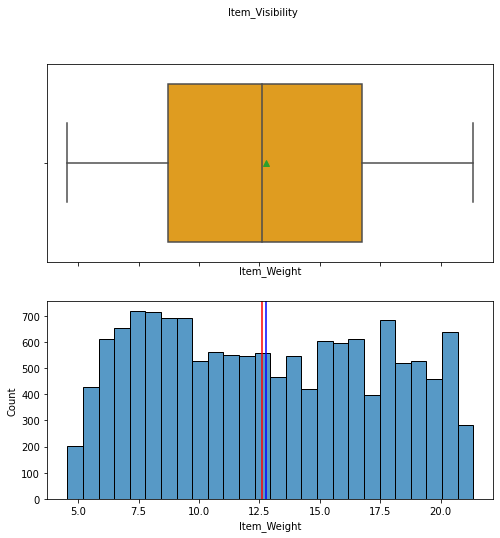

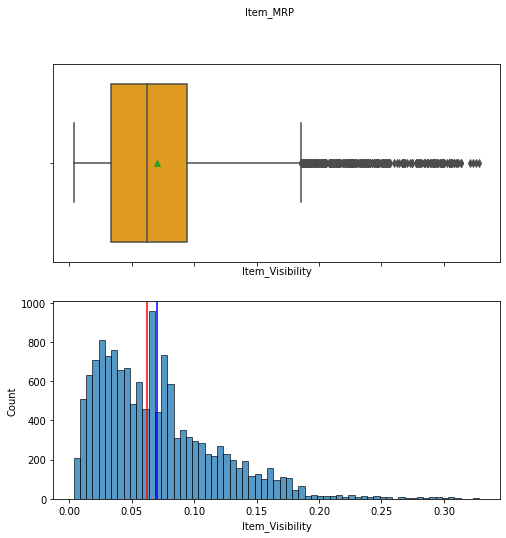

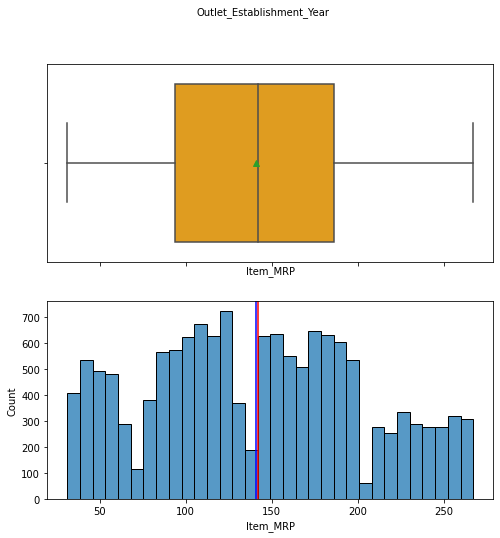

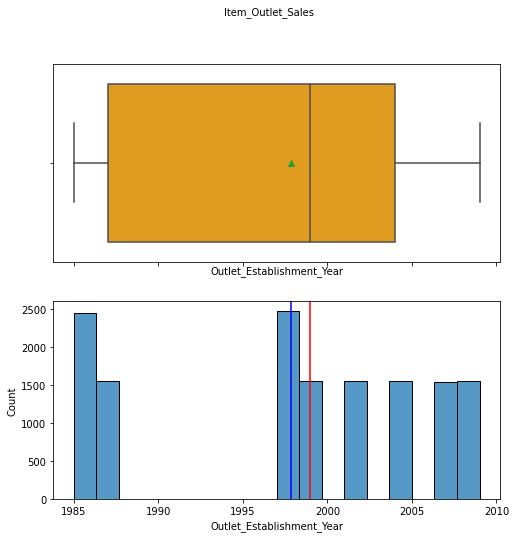

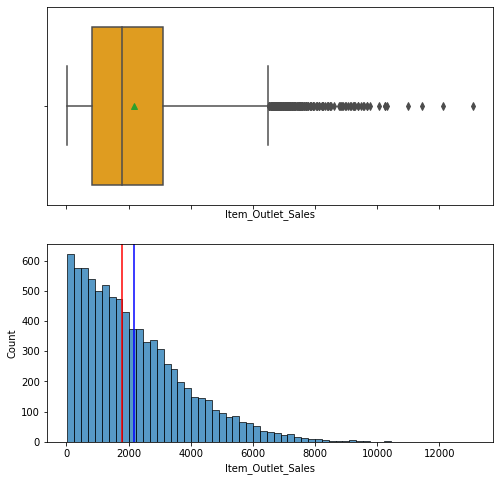

In [15]:
 # Creating box plot and histogram for age column blue line represents  mean and redline repredents the median
numeric_col= sales_df.select_dtypes("number").columns
for i in numeric_col:
  plt.suptitle(i,size = 10)
  histogram_boxplot(sales_df,i)

There are some outliers in few newmeric colums.So we have to perform outlier treatment.

In [16]:
# categorical columns
cat_col= sales_df.select_dtypes("object").columns
cat_col

Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [17]:
# function for bar plots for catagorical columns
def bar(df,i):
  plt.suptitle(i,size = 20)
  g = df[i].value_counts()
  h=pd.DataFrame({"ind":g.index,"value":g.values})
  plt.barh(h["ind"].values,h["value"].values,color ="c",edgecolor='black')
  plt.show()

Bar plots for catagorical columns

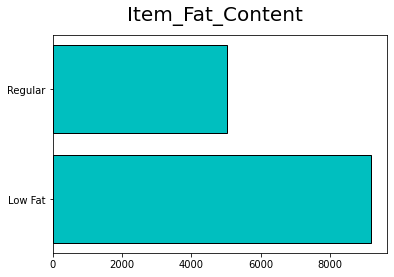

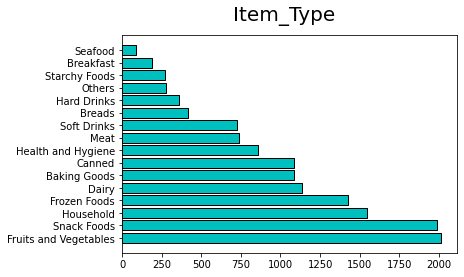

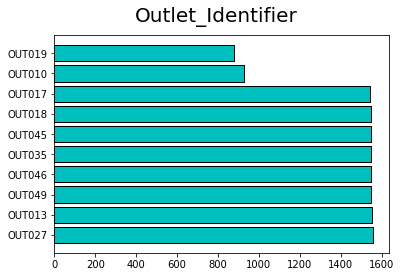

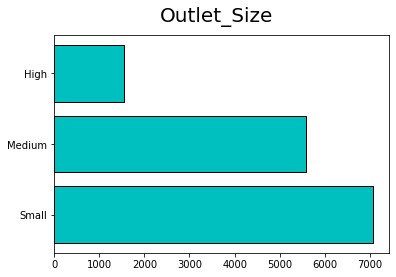

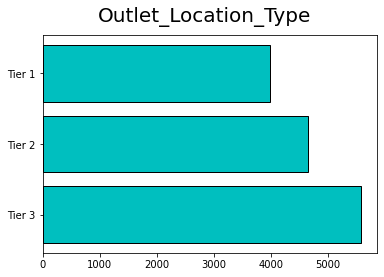

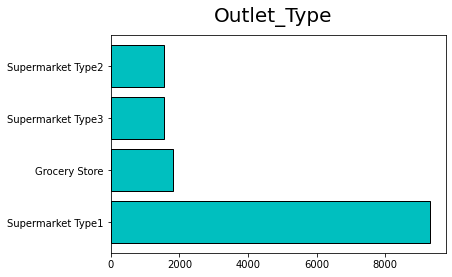

In [18]:
# barplots for all categorical columns

for i in cat_col:
  bar(sales_df,i)

Outlier treatment

In [19]:
 # Function for outlier treatment

for col in numeric_col:

    quartile_3 = sales_df[col].quantile(.75) 
    quartile_1 = sales_df[col].quantile(.25)

    IQR = quartile_3 - quartile_1 # inter quartine range

    upper_f = quartile_3 + 1.5 * IQR

    lower_f = quartile_1 - 1.5 * IQR

    index1 = sales_df[sales_df [col]>upper_f]. index

    index2 = sales_df[sales_df [col]<lower_f].index
    
    sales_df.loc[index1, col]=sales_df[col].median()

    sales_df.loc[index2, col]=sales_df[col].median()

Box plots after Outlier treatment

<Figure size 432x288 with 0 Axes>

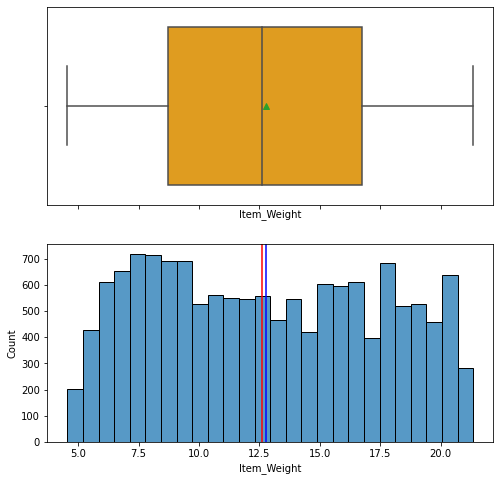

<Figure size 432x288 with 0 Axes>

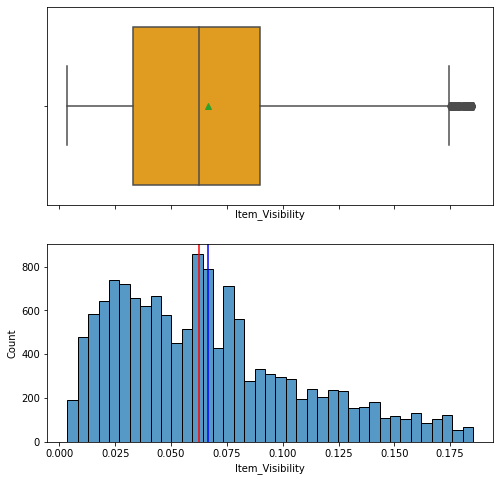

<Figure size 432x288 with 0 Axes>

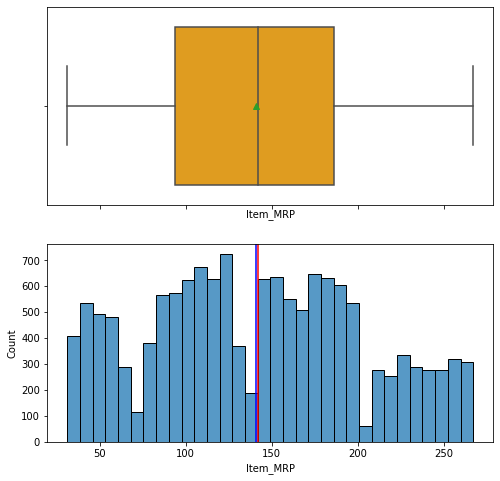

<Figure size 432x288 with 0 Axes>

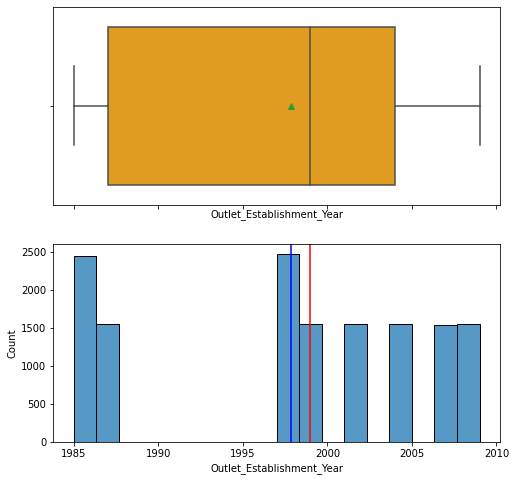

<Figure size 432x288 with 0 Axes>

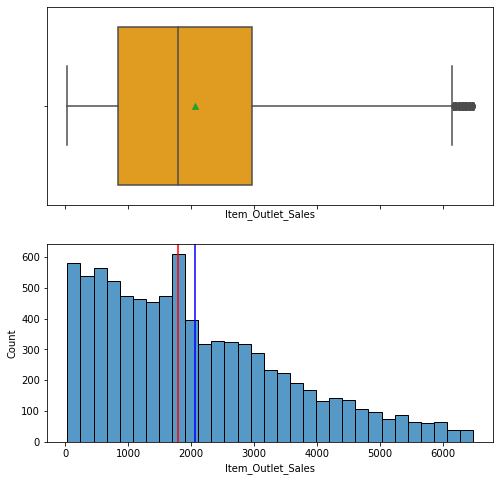

In [20]:
# Creating box plot and histogram for age column blue line represents  mean and redline repredents the median
numeric_col= sales_df.select_dtypes("number").columns
for i in numeric_col:
  plt.suptitle(i,size = 10)
  histogram_boxplot(sales_df,i)
  plt.show()

## Data visualization (Bi-variate)

In [21]:
# box plot
def visual_box(a,b,c):   # (a="other column" , b= "main column name",c="dataframe name")
    sns.boxplot(y = c[b], x = c[a])
    plt.show()

Relationship between sales and Item_Identifier

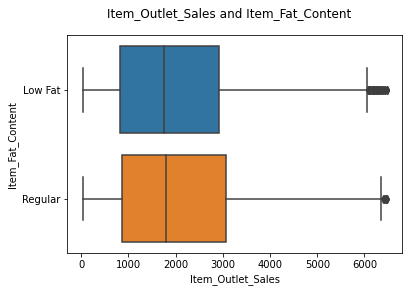

********************************************************************************


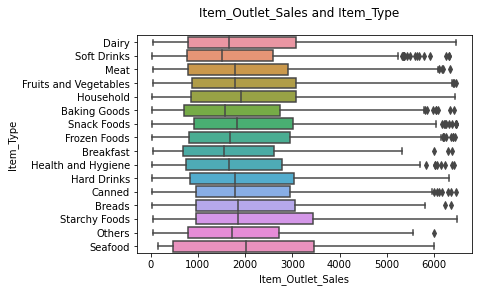

********************************************************************************


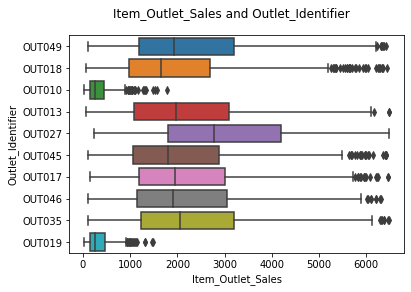

********************************************************************************


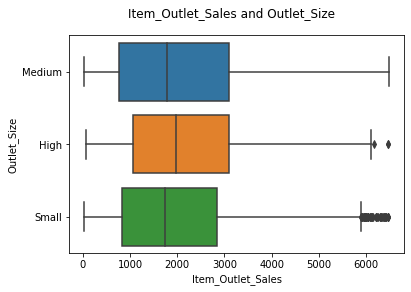

********************************************************************************


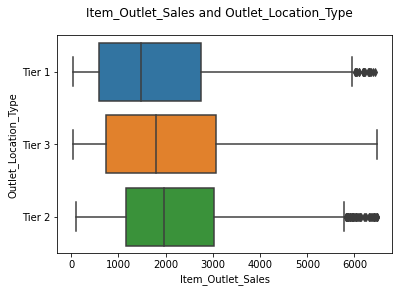

********************************************************************************


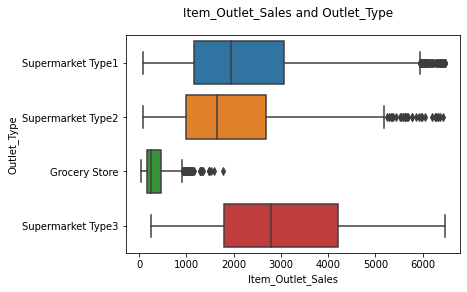

********************************************************************************


In [22]:
for i in cat_col:
  plt.suptitle("Item_Outlet_Sales and "+str(i))
  visual_box("Item_Outlet_Sales",i,sales_df)
  print(80*"*")

##### Grocery stor has lowest spread of sales a nd supermarket type 3 has the highest sales in outlet variable.
##### Tier 2 has the lowest sales and tier 3 has highest sales in outlet locktion type variable .
##### Small outlet size has the lowest avg sales and high outlet size has highest sales in outlet size variable .
##### OUT019 and OUT010 has the lowest avg sales and OUT027 has highest sales in outlet identifier variable .
##### In item type seafood has highest avg sales and Soft drinks has lowest .
##### For item fat content low and regular both has approximately same avg sales .

In [23]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

# encoding the purpose variable

for i in cat_col:
  if type(sales_df[i]=="object"):
    sales_df[i]=label_encoder.fit_transform(sales_df[i])

In [24]:
# corelaation
corr=sales_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
Item_Weight,1.000000,-0.033737,-0.011273,0.031884,0.035751,0.003002,0.000247,0.000944,-0.001719,0.001913,0.010230
Item_Fat_Content,-0.033737,1.000000,0.047225,-0.147733,-0.004019,-0.001095,0.000137,-0.000827,0.001373,-0.000228,0.023473
Item_Visibility,-0.011273,0.047225,1.000000,-0.036771,-0.004776,-0.047215,-0.040931,0.014885,-0.008662,-0.072923,-0.067154
Item_Type,0.031884,-0.147733,-0.036771,1.000000,0.043948,0.001126,0.003061,-0.001080,0.002083,0.004305,0.017919
Item_MRP,0.035751,-0.004019,-0.004776,0.043948,1.000000,-0.000555,0.000141,-0.001305,0.000838,0.000136,0.535620
Outlet_Identifier,0.003002,-0.001095,-0.047215,0.001126,-0.000555,1.000000,0.079047,0.423623,-0.716151,0.099899,0.179848
Outlet_Establishment_Year,0.000247,0.000137,-0.040931,0.003061,0.000141,0.079047,1.000000,0.428387,-0.089328,-0.122519,0.009801
Outlet_Size,0.000944,-0.000827,0.014885,-0.001080,-0.001305,0.423623,0.428387,1.000000,-0.590677,-0.260496,-0.045987
Outlet_Location_Type,-0.001719,0.001373,-0.008662,0.002083,0.000838,-0.716151,-0.089328,-0.590677,1.000000,0.467251,0.055264
Outlet_Type,0.001913,-0.000228,-0.072923,0.004305,0.000136,0.099899,-0.122519,-0.260496,0.467251,1.000000,0.355929


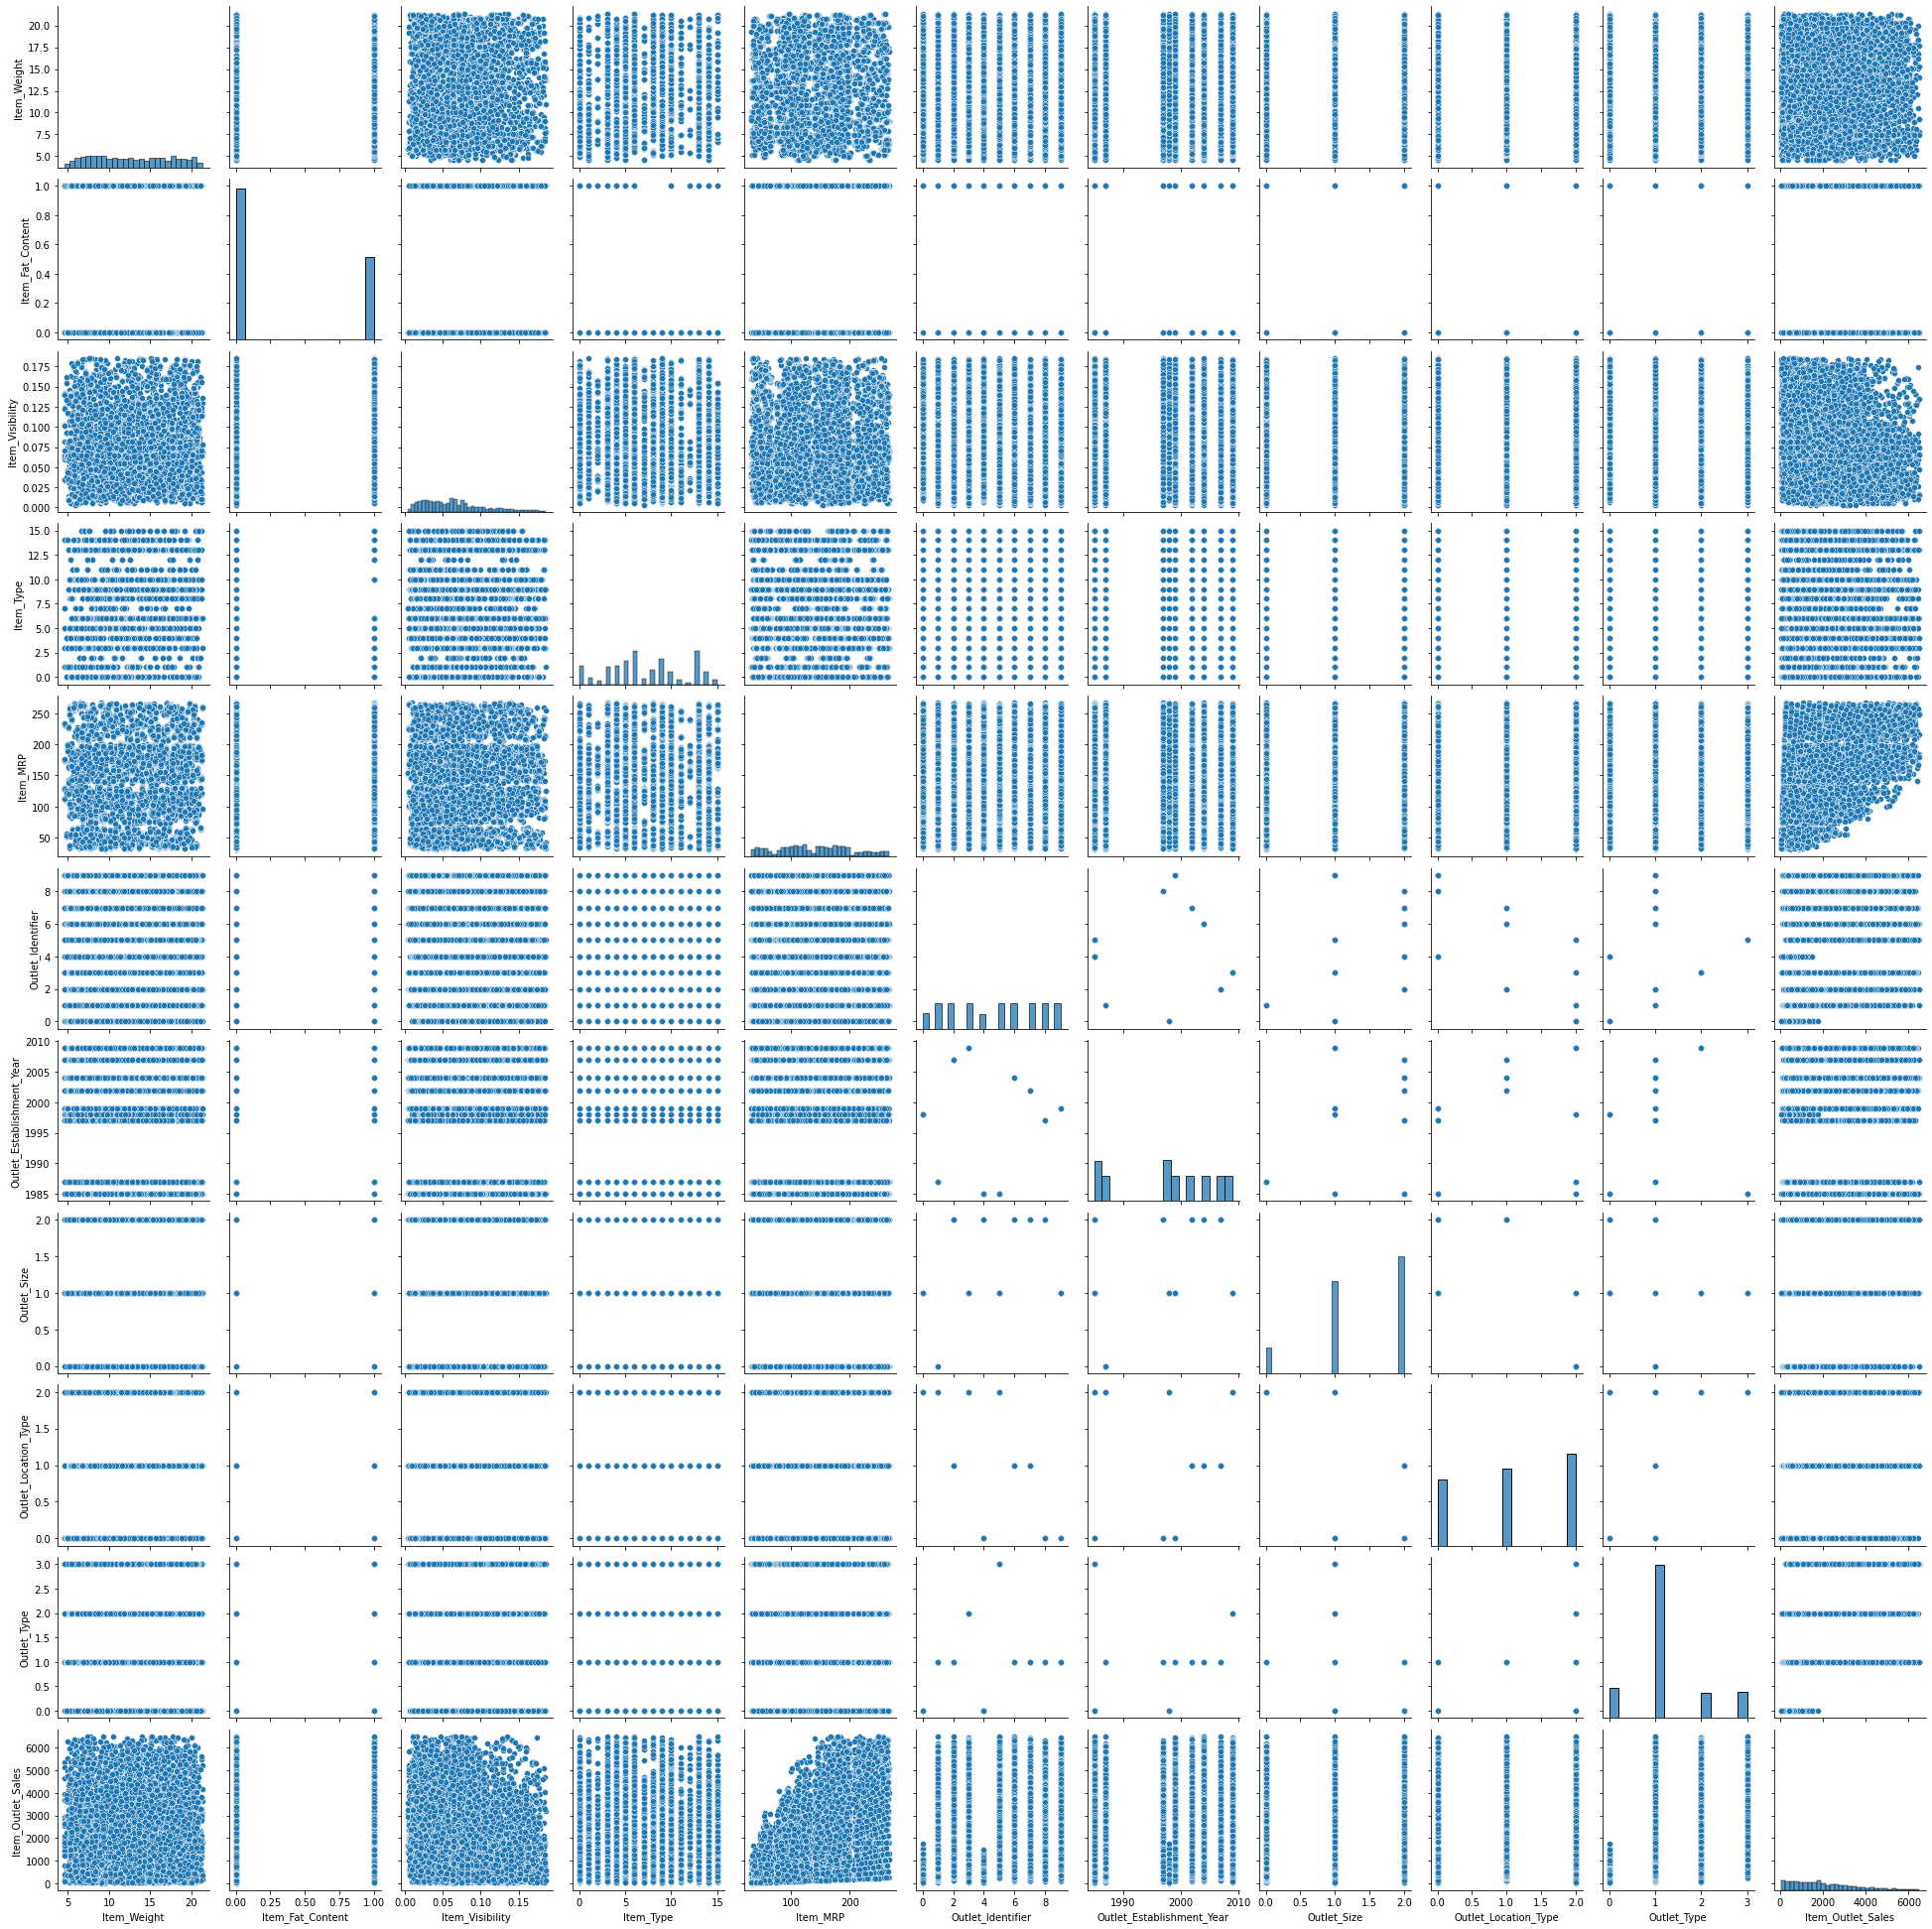

In [25]:
# creating scatterplots for all numerical collumns
sns.pairplot(sales_df,palette="Dark2")
plt.show()

Item_MRP has strong positive corelation and Outlet_Type,Outlet_Identifier has weak positive corealtion with the target variable(Item_Outlet_Sales).

In [26]:
# separating train data
train_df1 = sales_df[sales_df['Item_Outlet_Sales'].notnull()]

In [27]:
# separating test data
test_df1 = sales_df[sales_df['Item_Outlet_Sales'].isnull()]

#### Scaling the data

In [28]:
# scaling the data

from sklearn.preprocessing import MinMaxScaler

# Standardrizing data

scaler = MinMaxScaler()
data_scaled =pd.DataFrame(scaler.fit_transform(sales_df.to_numpy()),columns=sales_df.columns)
# we create the MinMaxScaler object, and then we perform .fit_transform() 
# then it will calculate  the maximum and minimum of the feature at a time it will transform the data points of the feature

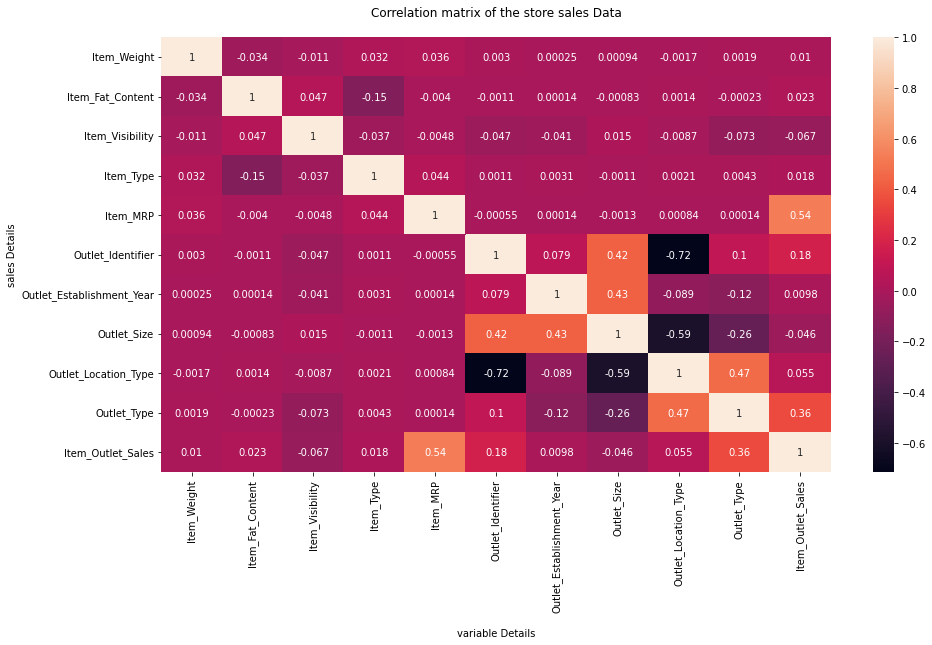

In [29]:
# Correlation Heatmap
plt.figure(figsize= (15,8))
hm = sns.heatmap(data_scaled.corr(), annot = True)
hm.set(xlabel='\nvariable Details', ylabel='sales Details', title = "Correlation matrix of the store sales Data\n")
plt.show()

Item_MRP has strong positive corelation and Outlet_Type,Outlet_Identifier has weak positive corealtion with the target variable(Item_Outlet_Sales)

In [30]:
data_scaled.isnull().sum()

Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
dtype: int64

Train test split

In [31]:
# separating train data
train_df = data_scaled[data_scaled['Item_Outlet_Sales'].notnull()]

In [32]:
# shape of the train data
data_scaled.shape

(14204, 11)

In [33]:
# separating test data
test_df = data_scaled[data_scaled['Item_Outlet_Sales'].isnull()]

In [34]:
# shape of the test data
test_df.shape

(5681, 11)

Train test data

In [35]:
y_train = train_df1.loc[:,"Item_Outlet_Sales"]
y_test = test_df1.loc[:,"Item_Outlet_Sales"]
X_train=train_df.drop(columns=["Item_Outlet_Sales"],axis=1)
X_test=test_df.drop(columns=["Item_Outlet_Sales"],axis=1)

## Model building

#### Linear regression model

In [36]:
# creating DataFrame
Model = pd.DataFrame()

In [37]:
# creating linear regression model

m1=LinearRegression()
Linear_regression = m1.fit(X_train,y_train)

In [38]:
# predicted values for test data
model1_predict_test_y = Linear_regression.predict(X_test)

In [39]:
Model["Predicted_LR"] = model1_predict_test_y
Model.head()

,Predicted_LR
0,1989.303798
1,1161.479804
2,2135.346404
3,1991.795106
4,4283.616251


In [40]:
# predicted values for train data
model1_predict_test_y_train = Linear_regression.predict(X_train)

In [42]:
# R2 and RMSE calculation for simple Linear Regression model
R2_1 = Linear_regression.score(X_train,y_train)
e1 = mean_squared_error(y_train,model1_predict_test_y_train,squared=False)

print("R2 value of train data =",np.round(R2_1*100,2),"%")
print("\nRMSE L.Regression =",e1)

R2 value of train data = 43.98 %

RMSE L.Regression = 1115.2249229293388


>>For Linear regression rmse value is 0.17 and R2 value is about of 43.98% for train , so we can consider the model .

#### Bagging With Random Forest

In [43]:
# random forestg model  

forest1 = RandomForestRegressor(n_estimators = 100, random_state=1,n_jobs = -1,criterion="squared_error",oob_score=True)
# n_estimators = int, default=100 ,The number of trees in the forest.

# oob_score = bool, default=False,Whether to use out-of-bag samples to estimate the generalization score.
# n_jobs : This parameter is used to specify how many concurrent processes should be used for creating the model.
# (n_jobs = -1, all CPUs are used.)

forest1.fit(X_train,y_train)

RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=1)

In [44]:
# checking the oob score in there
print("there is oob value =" ,forest1.oob_score)
print("\noob_score =",np.round(forest1.oob_score_*100,3),"%")

there is oob value = True

oob_score = 48.881 %


In [45]:
 # predection(test)

model2_predict_test_y = forest1.predict(X_test)

In [46]:
Model["Predicted_RF"] = model2_predict_test_y
Model.head()

,Predicted_LR,Predicted_RF
0,1989.303798,1662.848816
1,1161.479804,1227.595382
2,2135.346404,703.151380
3,1991.795106,2497.369194
4,4283.616251,3089.078970


In [47]:
 # predection(train)

model2_predict_train_y = forest1.predict(X_train)

In [48]:
R2_3=forest1.score(X_train,y_train)
e2 = mean_squared_error(y_train,model2_predict_train_y,squared=False)

print("R2 value of train data =",np.round(R2_3*100,2),"%")
print("\nRMSE R.forest.Regression =",e2)

R2 value of train data = 92.99 %

RMSE R.forest.Regression = 394.6227771334007


>>For Bagging With Random Forest rmse value is 0.061 and R2 value is about of 92.98 % for train , so we can consider the model .

#### Boosting using Adaboost

In [49]:
 # define the model
m2 = AdaBoostRegressor()

# evaluate the model
ada_model = m2.fit(X_train,y_train)

In [50]:
# prediction _test
y_pred_3_test = ada_model.predict(X_test)

# prediction Train
y_pred_3_train = ada_model.predict(X_train)

In [51]:
Model["Predicted_AB"] = y_pred_3_test
Model.head()

,Predicted_LR,Predicted_RF,Predicted_AB
0,1989.303798,1662.848816,1762.606265
1,1161.479804,1227.595382,1593.990868
2,2135.346404,703.151380,586.716714
3,1991.795106,2497.369194,2970.897641
4,4283.616251,3089.078970,3656.768645


In [52]:
R2_5=ada_model.score(X_train,y_train)
# report performance
e4 = mean_squared_error(y_train,y_pred_3_train,squared=False)

print("R2 value of train data =",np.round(R2_5*100,2),"%")
print("\nRMSE R.forest.Regression.H =",e4)

R2 value of train data = 50.14 %

RMSE R.forest.Regression.H = 1052.1341896105353


>>For Boosting using Adaboost rmse value is 0.16 and R2 value is about of 52 % for train , so we can consider the model .

#### Stacking

In [53]:
# required Python libraries for stacking
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor

In [54]:
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('lr', LinearRegression()))
    level0.append(('knn', KNeighborsRegressor()))
    level0.append(('cart', DecisionTreeRegressor()))
    level0.append(('svm', SVR()))
    
    # define meta learner model (meta model)
    level1 = LinearRegression()
    
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model

In [55]:
# define the model
m4 = get_stacking()

# evaluate the model
stack_model = m4.fit(X_train,y_train)

In [56]:
# prediction _test
y_pred_4_test = stack_model.predict(X_test)

# prediction Train
y_pred_4_train = stack_model.predict(X_train)

In [57]:

Model["Predicted_ST"] = y_pred_4_test
Model.head()

,Predicted_LR,Predicted_RF,Predicted_AB,Predicted_ST
0,1989.303798,1662.848816,1762.606265,2065.573678
1,1161.479804,1227.595382,1593.990868,1188.804487
2,2135.346404,703.151380,586.716714,1287.260493
3,1991.795106,2497.369194,2970.897641,2129.923839
4,4283.616251,3089.078970,3656.768645,3850.987511


In [58]:
R2_7=stack_model.score(X_train,y_train)
e5 = mean_squared_error(y_train,y_pred_4_train,squared=False)

print("R2 value of train data =",np.round(R2_7*100,2),"%")
print("\nRMSE R.forest.Regression =",e5)

R2 value of train data = 63.52 %

RMSE R.forest.Regression = 899.91355637835


>>For Random forest rmse value is 0.146 and R2 value is about of 60.01 % for train , so we can consider the model .

### Evaluate the Best Model

In [59]:
# model performance for comparison
models =pd.DataFrame({"Model_Name":["Linear.R","Random Forest","Adaboost","Stacking"],"Train_R2":[R2_1,R2_3,R2_5,R2_7],
             "rmse":[e1,e2,e4,e5]})
models

,Model_Name,Train_R2,rmse
0,Linear.R,0.439780,1115.224923
1,Random Forest,0.929855,394.622777
2,Adaboost,0.501373,1052.134190
3,Stacking,0.635216,899.913556


In [60]:
# creating function to plot performance for comparison 

def plot_s(x1,y1,z1,k1):
    
    for bar in x1.patches:
        plt.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width() / 2,bar.get_height())
                     , ha='center', va='center',size=15, xytext=(0, 8),textcoords='offset points')
    # Setting the label for x-axis
    plt.xlabel(y1, size=14)

    # Setting the label for y-axis
    plt.ylabel(z1, size=20)

    # Setting the title for the graph
    plt.title(k1,size=20)

    # Finally showing the plot
    plt.show()

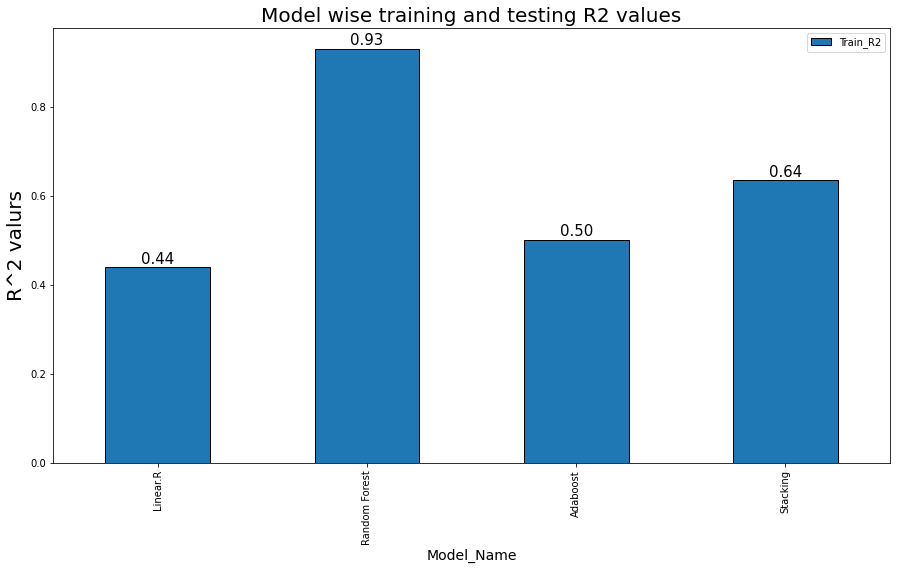

In [61]:
# plotting model performance for comparison 

import matplotlib.pyplot as plt
fig,ax1= plt.subplots(1,1,figsize=(15,8))
x1=models.plot(x="Model_Name", y=[ "Train_R2"], kind="bar",ax=ax1,edgecolor='black')

plot_s(x1,"Model_Name","R^2 valurs","Model wise training and testing R2 values")

>>**Random forest gives us highest R^2 around 93% and linear regression has lowest R^2 44% .**

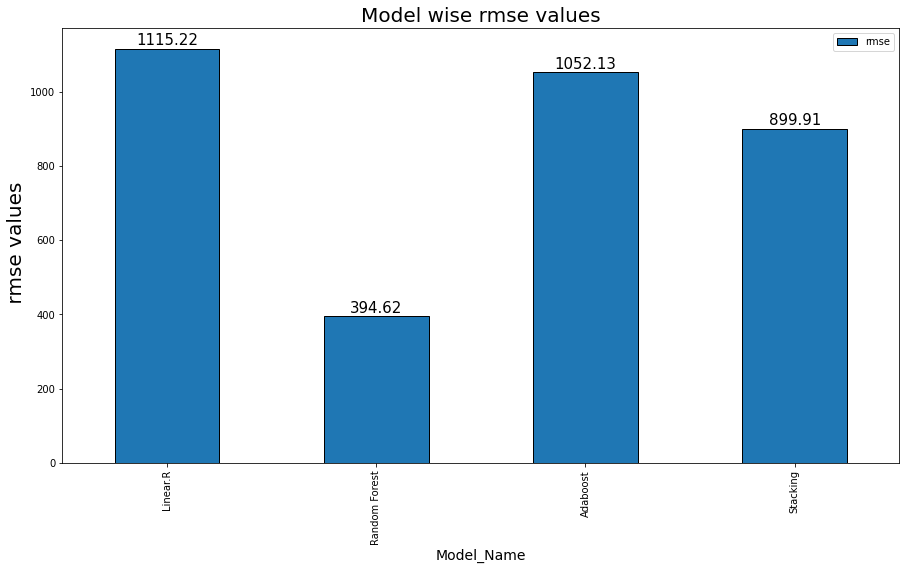

In [69]:
# plotting model performance for comparison 

fig,ax1= plt.subplots(1,1,figsize=(15,8)) 
x2=models.plot(x="Model_Name", y=["rmse"], kind="bar",ax=ax1,edgecolor='black')

plot_s(x2,"Model_Name"," rmse values","Model wise rmse values")

> **Random forest gives us lowest RMSE(0.06) values and linear regression has the highest RMSE(0.17) followed by Adaboost(0.16) and Stacking(0.15) .**

In [63]:
Train_df = pd.DataFrame({"Train_y":y_train.values})
Train_df.tail(2)

,Train_y
8521,1845.5976
8522,765.6700


In [64]:
# chanding the index of the rows

start = len(train_df)
stop =len(train_df)+len(test_df)
ind = np.arange(start,stop)
Model.set_index(ind,inplace =True)

In [65]:
Model.head(2)

,Predicted_LR,Predicted_RF,Predicted_AB,Predicted_ST
8523,1989.303798,1662.848816,1762.606265,2065.573678
8524,1161.479804,1227.595382,1593.990868,1188.804487


In [66]:
Model.tail(2)

,Predicted_LR,Predicted_RF,Predicted_AB,Predicted_ST
14202,2761.097676,3579.260904,3262.329066,3351.040116
14203,1248.356628,1338.997038,1087.107788,1240.477460


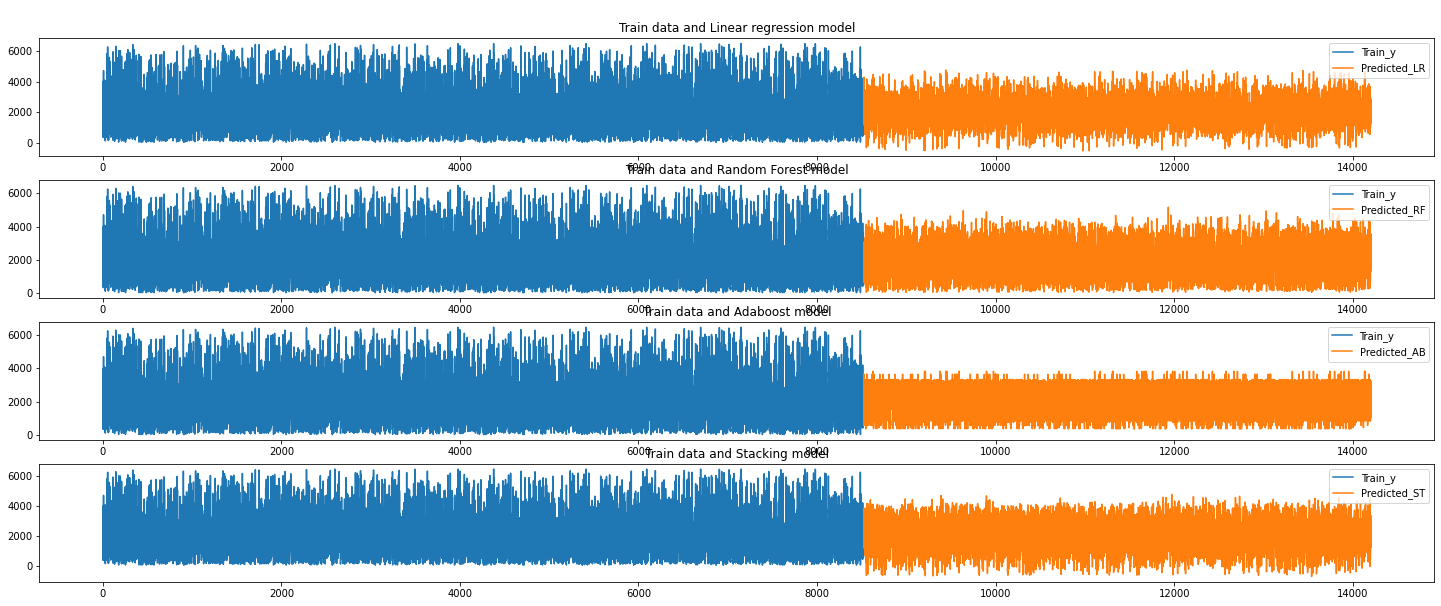

In [67]:
# plotting the actual - predicted error
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(25,10))

Train_df["Train_y"].plot(legend=True,ax=ax1)
Model["Predicted_LR"].plot(ax=ax1,legend=True)
ax1.set_title("\nTrain data and Linear regression model")

Train_df["Train_y"].plot(legend=True,ax=ax2)
Model["Predicted_RF"].plot(ax=ax2,legend=True)
ax2.set_title("\nTrain data and Random Forest model")

Train_df["Train_y"].plot(legend=True,ax=ax3)
Model["Predicted_AB"].plot(ax=ax3,legend=True)
ax3.set_title("\nTrain data and Adaboost model")

Train_df["Train_y"].plot(legend=True,ax=ax4)
Model["Predicted_ST"].plot(ax=ax4,legend=True)
ax4.set_title("\nTrain data and Stacking model")

plt.show()

### Conclusion 

####  **From the graphs we can see that randam forest gives us best result with low RMSE (error) and high R^2 value . So , Random forest is the best model to predict the store sales in future .**